<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra


## Alumno: Fux, Santiago Javier (CEIA-6ta Cohorte)
### Fecha: 2023-03-27

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

2023-03-27 17:16:11.506147: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-27 17:16:11.506167: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [ ]:
# Posibles bandas
# os.listdir("./songs_dataset/")

In [2]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('./redondos.txt', sep='/n', header=None)
df.head()

/tmp/ipykernel_990294/1877459069.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('./redondos.txt', sep='/n', header=None)


,0
0,Alien duce adorno tu esclavitud
1,y en un edificio en llamas te encanó
2,Nadando en ese minestrón
3,va Porco Rex a Porno Rock!
4,"Si su looz""bola de efectos"" te palmó"


In [3]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 2086


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [5]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
#from keras.utils import pad_sequences # se utilizará para padding
from keras_preprocessing.sequence import pad_sequences

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [6]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.loc[0,0]
text

'Alien duce adorno tu esclavitud'

In [7]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['alien', 'duce', 'adorno', 'tu', 'esclavitud']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [8]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [9]:
# Demos un vistazo
sentence_tokens[:2]

[['alien', 'duce', 'adorno', 'tu', 'esclavitud'],
 ['y', 'en', 'un', 'edificio', 'en', 'llamas', 'te', 'encanó']]

In [18]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens) + 1):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [20]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences 

[['alien', 'duce', 'adorno', 'tu'], ['duce', 'adorno', 'tu', 'esclavitud']]

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [23]:
tok = Tokenizer() 

# El tokeinzer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado, esta sutileza nos dará un pequeño
# problema al momento de hacer la codificación OHE, pero es sencillo de resolver
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [24]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[4, 1, 2, 3], [1, 2, 3, 5]]

In [25]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

2


In [26]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

5


In [27]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'duce': 1, 'adorno': 2, 'tu': 3, 'alien': 4, 'esclavitud': 5}


In [28]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'duce': 2, 'alien': 1, 'adorno': 2, 'tu': 2, 'esclavitud': 1})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [29]:
# Vistazo a las primeras filas
df.loc[:15,0]

0              Alien duce adorno tu esclavitud
1         y en un edificio en llamas te encanó
2                     Nadando en ese minestrón
3                   va Porco Rex a Porno Rock!
4         Si su looz"bola de efectos" te palmó
5          y recogés tu hígado desde un rincón
6                   Flotando en este minedtrón
7                    va Porco rex a Porno Rock
8                  Vá escribiendo su evangelio
9                   en los ticket de Carrefour
10    Es el peque!no gran matón de la internet
11                 Alien duce dice desde la TV
12          que no quiere estar jamás en la TV
13                    Lo sobrevuela un gavilán
14                   que se hace pasar por el.
15                               El alien duce
Name: 0, dtype: object

In [30]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'Alien duce adorno tu esclavitud y en un edificio en llamas te encanó Nadando en ese minestrón va Porco Rex a Porno Rock! Si su looz"bola de efectos" te palmó y recogés tu hígado desde un rincón Flotando en este minedtrón va Porco rex a Porno Rock Vá escribiendo su evangelio en los ticket de Carrefour Es el peque!no gran matón de la internet Alien duce dice desde la TV que no quiere estar jamás en la TV Lo sobrevuela un gavilán que se hace pasar por el. El alien duce chupa y escupe al fin Para alien duce Dios es digital. Alien duce adorno tu esclavitud y en un edificio en llamas te encanó Nadando en ese minestrón va Porco Rex a Porno Rock! Si su looz"bola de efectos" te palmó y recogés tu hígado desde un rincón Flotando en este minestrón va Porco rex a Porno Rock Vá escribiendo su evangelio en los ticket de Carrefour Es el peque!no gran matón de la internet Alien duce dice desde la TV que no quiere estar jamás en la TV Lo sobrevuela un gavilán que se hace pasar por el. El alien duce ch

In [31]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['alien',
 'duce',
 'adorno',
 'tu',
 'esclavitud',
 'y',
 'en',
 'un',
 'edificio',
 'en',
 'llamas',
 'te',
 'encanó',
 'nadando',
 'en',
 'ese',
 'minestrón',
 'va',
 'porco',
 'rex']

In [32]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 11184


In [33]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [34]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['alien', 'duce', 'adorno', 'tu'],
 ['duce', 'adorno', 'tu', 'esclavitud'],
 ['adorno', 'tu', 'esclavitud', 'y'],
 ['tu', 'esclavitud', 'y', 'en'],
 ['esclavitud', 'y', 'en', 'un'],
 ['y', 'en', 'un', 'edificio'],
 ['en', 'un', 'edificio', 'en'],
 ['un', 'edificio', 'en', 'llamas'],
 ['edificio', 'en', 'llamas', 'te'],
 ['en', 'llamas', 'te', 'encanó'],
 ['llamas', 'te', 'encanó', 'nadando'],
 ['te', 'encanó', 'nadando', 'en'],
 ['encanó', 'nadando', 'en', 'ese'],
 ['nadando', 'en', 'ese', 'minestrón'],
 ['en', 'ese', 'minestrón', 'va'],
 ['ese', 'minestrón', 'va', 'porco'],
 ['minestrón', 'va', 'porco', 'rex'],
 ['va', 'porco', 'rex', 'a'],
 ['porco', 'rex', 'a', 'porno'],
 ['rex', 'a', 'porno', 'rock']]

In [35]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[180, 179, 1081, 11],
 [179, 1081, 11, 602],
 [1081, 11, 602, 2],
 [11, 602, 2, 8],
 [602, 2, 8, 9],
 [2, 8, 9, 603],
 [8, 9, 603, 8],
 [9, 603, 8, 214],
 [603, 8, 214, 19],
 [8, 214, 19, 604],
 [214, 19, 604, 605],
 [19, 604, 605, 8],
 [604, 605, 8, 105],
 [605, 8, 105, 419],
 [8, 105, 419, 30],
 [105, 419, 30, 314],
 [419, 30, 314, 315],
 [30, 314, 315, 6],
 [314, 315, 6, 215],
 [315, 6, 215, 78]]

In [36]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 11180


### 3 - Input y target

In [37]:
# # Con numpy es muy fácil realizar el slicing de vectores
# ex = np.array([[1,2,3,4],[5,6,7,8]])
# ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [38]:
# # Con numpy es muy fácil realizar el slicing de vectores
# print("Dimension:", ex.shape)
# print("Todos los elementos:", ex)
# print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [39]:
# input = ex[:,:-1] # todos los rows, menos la ultima col
# target = ex[:, -1] # última col de cada row

# print("Input:", input)
# print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [40]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(11180, 3)
(11180,)


In [41]:
# Palabras del vocabulario
tok.index_word

{1: 'de',
 2: 'y',
 3: 'la',
 4: 'que',
 5: 'el',
 6: 'a',
 7: 'no',
 8: 'en',
 9: 'un',
 10: 'es',
 11: 'tu',
 12: 'mi',
 13: 'se',
 14: 'si',
 15: 'del',
 16: 'con',
 17: 'los',
 18: 'más',
 19: 'te',
 20: 'por',
 21: 'su',
 22: 'lo',
 23: 'para',
 24: 'me',
 25: 'amor',
 26: 'las',
 27: 'todo',
 28: 'ya',
 29: 'como',
 30: 'va',
 31: 'sin',
 32: 'al',
 33: 'una',
 34: 'le',
 35: 'tan',
 36: 'esta',
 37: 'ay',
 38: 'vas',
 39: 'este',
 40: 'vez',
 41: 'así',
 42: 'sus',
 43: 'vos',
 44: 'voy',
 45: 'dios',
 46: 'está',
 47: 'otra',
 48: 'muy',
 49: 'son',
 50: 'hay',
 51: 'mucho',
 52: 'pero',
 53: 'puede',
 54: 'nada',
 55: 'tus',
 56: 'ojos',
 57: 'fuego',
 58: 'oh',
 59: 'corazón',
 60: 'quiere',
 61: 'yo',
 62: 'vamos',
 63: 'nunca',
 64: 'murga',
 65: 'sheriff',
 66: 'van',
 67: 'siempre',
 68: 'da',
 69: 'ser',
 70: 'mas',
 71: 'ella',
 72: 'tiempo',
 73: 'cuando',
 74: 'brillar',
 75: 'mal',
 76: 'mis',
 77: 'bien',
 78: 'rock',
 79: 'estás',
 80: 'suerte',
 81: 'sos',
 82: 'v

In [42]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

3042

In [44]:
# Transformar los datos a oneHotEncoding
y_data = to_categorical(y_data_int, num_classes=vocab_size+1)

In [45]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [46]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(11180, 3042)

### 4 - Entrenar el modelo

In [47]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [48]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

3042

In [49]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

2023-03-27 17:25:37.088342: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-27 17:25:37.088374: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-27 17:25:37.088395: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (santiago-ubuntu): /proc/driver/nvidia/version does not exist
2023-03-27 17:25:37.089355: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 5)              15215     
                                                                 
 lstm (LSTM)                 (None, 3, 64)             17920     
                                                                 
 dropout (Dropout)           (None, 3, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 3042)              100386    
                                                                 
Total params: 168,625
Trainable params: 168,625
Non-trai

In [50]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50


2023-03-27 17:25:53.554496: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 108830592 exceeds 10% of free system memory.


280/280 [==============================] - 9s 15ms/step - loss: 7.0698 - accuracy: 0.0309 - val_loss: 7.1738 - val_accuracy: 0.0385
Epoch 2/50
280/280 [==============================] - 4s 13ms/step - loss: 6.5428 - accuracy: 0.0334 - val_loss: 7.4657 - val_accuracy: 0.0385
Epoch 3/50
280/280 [==============================] - 3s 12ms/step - loss: 6.4579 - accuracy: 0.0335 - val_loss: 7.6456 - val_accuracy: 0.0385
Epoch 4/50
280/280 [==============================] - 3s 12ms/step - loss: 6.3934 - accuracy: 0.0337 - val_loss: 7.9467 - val_accuracy: 0.0385
Epoch 5/50
280/280 [==============================] - 4s 13ms/step - loss: 6.3391 - accuracy: 0.0324 - val_loss: 7.9848 - val_accuracy: 0.0206
Epoch 6/50
280/280 [==============================] - 3s 12ms/step - loss: 6.2776 - accuracy: 0.0343 - val_loss: 8.2671 - val_accuracy: 0.0380
Epoch 7/50
280/280 [==============================] - 4s 13ms/step - loss: 6.2073 - accuracy: 0.0342 - val_loss: 8.2402 - val_accuracy: 0.0358
Epoch 8/50

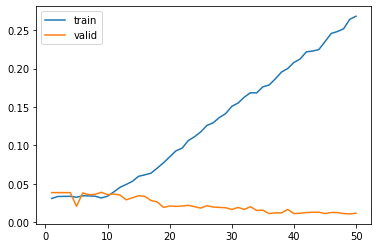

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [ ]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [52]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

In [56]:

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word


In [63]:
test_strings = [
  'dique que el',
  'vamos negrita canta',
  'en este film',
  'para alien duce',
  'susanita tan bonita',
  'miraba el cielo',
  'banderas en tu',
  'dice que el',
  'todo un palo',
  'el pibe de',
  'ciertos reyes no',
  'el infierno esta',
  'quemando la turbina',
  'a brillar mi'
]

In [64]:
for ts in test_strings:
  print(model_response(ts))

dique que el nova
vamos negrita canta que
en este film muere
para alien duce voy
susanita tan bonita sin
miraba el cielo lavi
banderas en tu vudú
dice que el maté
todo un palo 
el pibe de tu
ciertos reyes no reyes
el infierno esta caro
quemando la turbina roto
a brillar mi me


### 6 - Conclusiones
- Se observa un overfit muy grande dado que el accuracy de entrenamiento es muy alto y el de validación muy bajo.